In [16]:
import pandas as pd
import numpy as np
from shapely import geometry
from shapely.ops import cascaded_union
import os, glob

## 1.1 Process all contours

### name all contour positions as "contour_x.txt" before proceeding the step below

In [18]:
process_all_contours = True

if process_all_contours:
    
    data_folder = r'D:\Pu\20220226-P_brain_M1_nonclear'  
    contour_filename_list = [_f for _f in glob.glob(data_folder+os.sep+'*') if 'contour_' in _f and 'position' not in _f]
    print(f"Get position file for {len(contour_filename_list)} contours.")
    # merged positions for all positions
    postions_all = []
    
    for contour_filename in contour_filename_list:
        # read contour coords
        points = pd.read_csv(contour_filename, header=None, sep=',')
        points.columns=['X', 'Y']
        # convert to polygon
        
        grid_size = 200 # um

        tissue = geometry.Polygon(points.values)
        grid_center = np.round(np.array(tissue.centroid.coords)[0], 1)
        grid_inds = [np.arange(np.floor( (np.min(points['X'])-grid_center[0])/grid_size ), 
                      np.ceil( (max(points['X'])-grid_center[0])/grid_size )+1 ),
             np.arange(np.floor( (np.min(points['Y'])-grid_center[1])/grid_size ), 
                      np.ceil( (max(points['Y'])-grid_center[1])/grid_size )+1 ),
            ]
                
        grids = np.array(np.meshgrid(*grid_inds))#.reshape(len(grid_inds),-1).transpose()
        # generate tiles in snake style

        sorted_grids = []
        for _iy in np.arange(grids.shape[-1]):
            _line_grids = grids[:,:,_iy]
            if _iy % 2 == 0:
                sorted_grids.append(_line_grids)
            else:
                sorted_grids.append(np.fliplr(_line_grids))
        
        grids = np.concatenate(sorted_grids, axis=1).transpose()
        
        # get to positions coord inside the grid      
        positions = []

        for _i, _grid in enumerate(grids):
            _grid_position = _grid * grid_size + grid_center
            #print(_grid_position)
            # get each grid point
            _grid_point = geometry.Point(_grid_position)
            _fov_shape = geometry.Polygon([
                    _grid_position + [-grid_size/2, -grid_size/2], 
                    _grid_position + [grid_size/2, -grid_size/2], 
                    _grid_position + [grid_size/2, grid_size/2], 
                    _grid_position + [-grid_size/2, grid_size/2], 
                ])
            # calculate intersect
            _intersect = _fov_shape.intersection(tissue)
            if _intersect.area > 0:
                positions.append(_grid_position)
                postions_all.append(_grid_position)
        positions = np.array(positions)
        #print(np.shape(positions))
        
        
        overwrite = False
        save_filename = contour_filename.replace('.txt', '_positions.txt')

        if os.path.exists(save_filename) and not overwrite:
            print(f"file: {save_filename} already exist, skip!")
        else:
            print(f"save {len(positions)} coordinates into file: {save_filename}")
            np.savetxt(save_filename, np.round(positions,2), delimiter=',', fmt='%.2f')
    
    
    
postions_all =np.array(postions_all)
merged_save_filename = os.path.join(data_folder, r'positions_all.txt')
exp_date = data_folder.split('\\')[-1].split('-')[0]
analysis_save_filename = os.path.join(data_folder, f'{exp_date}_positions_all.txt')

if os.path.exists(merged_save_filename) and not overwrite:
    print(f"file: {merged_save_filename} already exist, skip!")
else:
    print(f"Save {len(postions_all)} coordinates into the merged file: {merged_save_filename}")
    np.savetxt(merged_save_filename, np.round(postions_all,2), delimiter=',', fmt='%.2f')
    #np.savetxt(analysis_save_filename, np.round(postions_all,2), delimiter=',', fmt='%.2f')
    



Get position file for 4 contours.
save 49 coordinates into file: D:\Pu\20220226-P_brain_M1_nonclear\contour_0_positions.txt
save 39 coordinates into file: D:\Pu\20220226-P_brain_M1_nonclear\contour_1_positions.txt
save 47 coordinates into file: D:\Pu\20220226-P_brain_M1_nonclear\contour_2_positions.txt
save 44 coordinates into file: D:\Pu\20220226-P_brain_M1_nonclear\contour_3_positions.txt
Save 179 coordinates into the merged file: D:\Pu\20220226-P_brain_M1_nonclear\positions_all.txt


## (Alternatively) 1.2 Check individual contour

In [8]:
data_folder = r'D:\Pu\20220222-P_brain_M1_noclear'
contour_filename = os.path.join(data_folder, r'contour_3.txt')
# read position file
if os.path.exists(contour_filename):
    points = pd.read_csv(contour_filename, header=None, sep=',')
points.columns=['X', 'Y']
points

,X,Y
0,4084.46,-270.67
1,4022.34,-536.90
2,4015.69,-718.83
3,2538.09,-721.05
4,2542.53,-317.26
5,2542.53,-22.19
6,2631.27,408.22
7,2728.36,571.87


In [9]:
# convert into polygon
grid_size = 200 # um

tissue = geometry.Polygon(points.values)

grid_center = np.round(np.array(tissue.centroid.coords)[0], 1)

grid_inds = [np.arange(np.floor( (np.min(points['X'])-grid_center[0])/grid_size ), 
                      np.ceil( (max(points['X'])-grid_center[0])/grid_size )+1 ),
             np.arange(np.floor( (np.min(points['Y'])-grid_center[1])/grid_size ), 
                      np.ceil( (max(points['Y'])-grid_center[1])/grid_size )+1 ),
            ]
                
grids = np.array(np.meshgrid(*grid_inds))#.reshape(len(grid_inds),-1).transpose()
# generate tiles in snake style

sorted_grids = []
for _iy in np.arange(grids.shape[-1]):
    _line_grids = grids[:,:,_iy]
    if _iy % 2 == 0:
        sorted_grids.append(_line_grids)
    else:
        sorted_grids.append(np.fliplr(_line_grids))
        
grids = np.concatenate(sorted_grids, axis=1).transpose()

In [10]:
positions = []

for _i, _grid in enumerate(grids):
    _grid_position = _grid * grid_size + grid_center
    #print(_grid_position)
    # get each grid point
    _grid_point = geometry.Point(_grid_position)
    _fov_shape = geometry.Polygon([
            _grid_position + [-grid_size/2, -grid_size/2], 
            _grid_position + [grid_size/2, -grid_size/2], 
            _grid_position + [grid_size/2, grid_size/2], 
            _grid_position + [-grid_size/2, grid_size/2], 
        ])
    # calculate intersect
    _intersect = _fov_shape.intersection(tissue)
    if _intersect.area > 0:
        positions.append(_grid_position)
        
positions = np.array(positions)
print(np.shape(positions))

(44, 2)


## Plot

In [11]:
#positions[54]

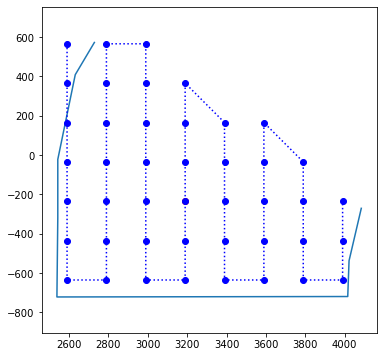

44


In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot(points['X'], points['Y'])
plt.axis('equal')
plt.plot(grid_center[0], grid_center[1], 'ro')
#plt.axes('equal')
plt.plot(positions[:,0], positions[:,1], 'b:o')

plt.show()

print(len(positions))

## Save

In [78]:
overwrite = False
save_filename = contour_filename.replace('.txt', '_positions.txt')

if os.path.exists(save_filename) and not overwrite:
    print(f"file: {save_filename} already exist, skip!")
else:
    print(f"save {len(positions)} coordinates into file: {save_filename}")
    np.savetxt(save_filename, np.round(positions,2), delimiter=',', fmt='%.2f')

save 58 coordinates into file: D:\Pu\20220204-P_brain_M1_nonclear\contour_3_positions.txt
